## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io, img_as_ubyte
from PIL import Image
import requests
from io import BytesIO
import time
import sys

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Sample Image

We'll load a colorful sample image that's ideal for demonstrating compression.

Loaded astronaut image. Shape: (512, 512, 3)


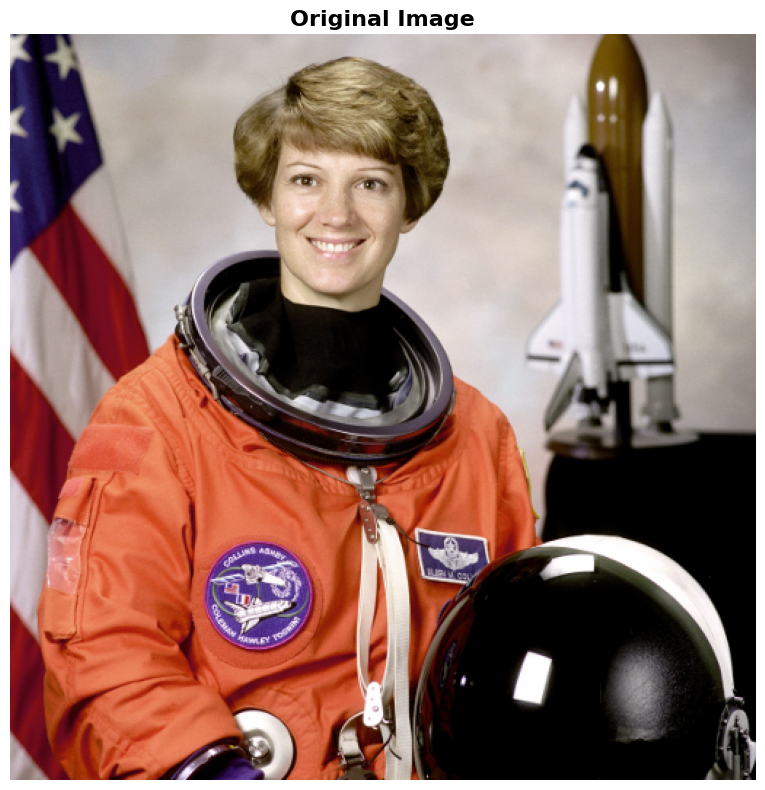


Image dimensions: 512 x 512 pixels
Total pixels: 262,144
Color channels: 3


In [2]:
# Load a sample image
try:
    # Try loading astronaut image from skimage
    from skimage import data
    image = data.astronaut()
    print(f"Loaded astronaut image. Shape: {image.shape}")
except:
    # Fallback to another image
    url = "https://raw.githubusercontent.com/scikit-image/scikit-image/main/skimage/data/astronaut.png"
    response = requests.get(url)
    image = np.array(Image.open(BytesIO(response.content)))
    print(f"Image loaded from URL. Shape: {image.shape}")

# Display original image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title('Original Image', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nImage dimensions: {image.shape[0]} x {image.shape[1]} pixels")
print(f"Total pixels: {image.shape[0] * image.shape[1]:,}")
print(f"Color channels: {image.shape[2]}")

## 3. Analyze Original Image

Let's examine the color distribution and memory usage of the original image.

Original Image Statistics:
Unique colors: 113,382
Memory usage: 786,432 bytes (768.00 KB)
Bits per pixel: 24 (RGB)


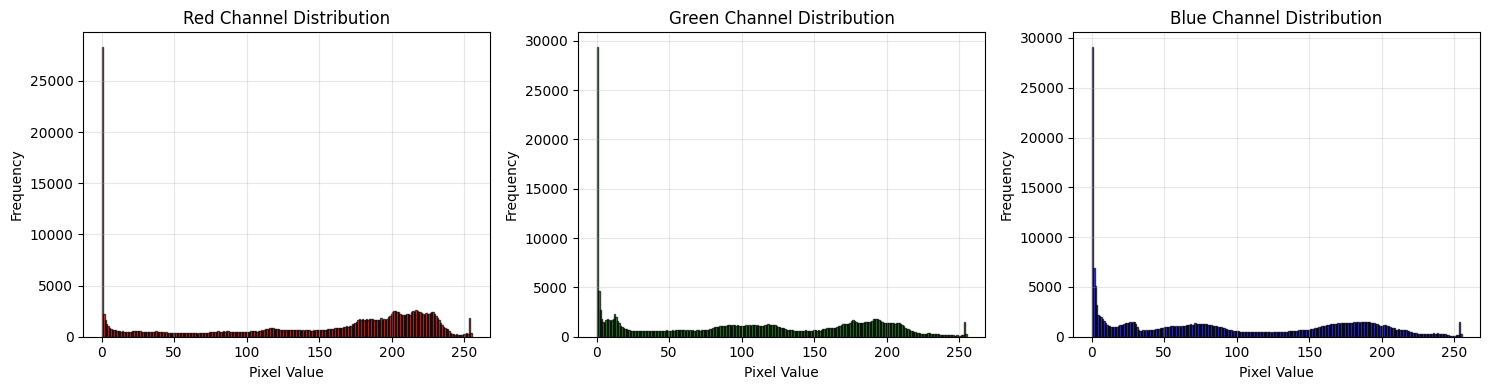

In [3]:
# Calculate unique colors in original image
original_shape = image.shape
pixels_2d = image.reshape(-1, 3)

# Count unique colors
unique_colors = np.unique(pixels_2d, axis=0)
num_unique_colors = len(unique_colors)

# Memory usage
memory_bytes = image.nbytes
memory_kb = memory_bytes / 1024

print("Original Image Statistics:")
print("=" * 50)
print(f"Unique colors: {num_unique_colors:,}")
print(f"Memory usage: {memory_bytes:,} bytes ({memory_kb:.2f} KB)")
print(f"Bits per pixel: {image.dtype.itemsize * 8 * 3} (RGB)")

# Show color distribution histogram
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['red', 'green', 'blue']
channels = ['Red', 'Green', 'Blue']

for i, (color, channel) in enumerate(zip(colors, channels)):
    axes[i].hist(image[:, :, i].ravel(), bins=256, color=color, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{channel} Channel Distribution', fontsize=12)
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Image Compression Function

Create a function to compress images using K-means clustering.

In [4]:
def compress_image_kmeans(image, n_colors, random_state=42):
    """
    Compress an image by reducing the number of colors using K-means.
    
    Parameters:
    - image: input image array (H x W x 3)
    - n_colors: number of colors to use (K clusters)
    - random_state: random seed for reproducibility
    
    Returns:
    - compressed_image: compressed image
    - kmeans: fitted KMeans model
    - compression_time: time taken for compression
    - compression_stats: dictionary with compression statistics
    """
    start_time = time.time()
    
    # Store original shape
    h, w, c = image.shape
    
    # Reshape to 2D array of pixels
    pixels = image.reshape(-1, 3).astype(np.float32)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=random_state, n_init=10)
    kmeans.fit(pixels)
    
    # Replace pixels with cluster centers
    compressed_pixels = kmeans.cluster_centers_[kmeans.labels_]
    
    # Reshape back to image
    compressed_image = compressed_pixels.reshape(h, w, c)
    compressed_image = np.uint8(compressed_image)
    
    compression_time = time.time() - start_time
    
    # Calculate compression statistics
    original_memory = image.nbytes
    
    # Compressed representation: cluster centers + labels
    # Cluster centers: n_colors * 3 * 4 bytes (float32)
    # Labels: num_pixels * log2(n_colors) bits
    centers_memory = n_colors * 3 * 4
    bits_per_label = int(np.ceil(np.log2(n_colors)))
    labels_memory = (h * w * bits_per_label) // 8
    compressed_memory = centers_memory + labels_memory
    
    compression_ratio = original_memory / compressed_memory
    
    stats = {
        'original_memory': original_memory,
        'compressed_memory': compressed_memory,
        'compression_ratio': compression_ratio,
        'space_saved_percent': (1 - compressed_memory/original_memory) * 100,
        'n_colors': n_colors,
        'inertia': kmeans.inertia_
    }
    
    return compressed_image, kmeans, compression_time, stats

print("Compression function defined!")

Compression function defined!


## 5. Compress Image with Different K Values

Let's compress the image with various numbers of colors: 2, 4, 8, 16, 32, 64, 128, and 256.

In [5]:
# Define different compression levels (number of colors)
k_values = [2, 4, 8, 16, 32, 64, 128, 256]

# Store results
compressed_images = {}
kmeans_models = {}
compression_times = {}
compression_stats = {}

print("Starting compression with different K values...\n")

for k in k_values:
    print(f"Compressing with K = {k:3d} colors... ", end='')
    comp_img, model, comp_time, stats = compress_image_kmeans(image, k)
    
    compressed_images[k] = comp_img
    kmeans_models[k] = model
    compression_times[k] = comp_time
    compression_stats[k] = stats
    
    print(f"Done! Time: {comp_time:.3f}s | Compression: {stats['compression_ratio']:.2f}x")

print("\nAll compressions complete!")

Starting compression with different K values...

Compressing with K =   2 colors... Done! Time: 0.799s | Compression: 23.98x
Compressing with K =   4 colors... Done! Time: 0.799s | Compression: 23.98x
Compressing with K =   4 colors... Done! Time: 1.659s | Compression: 11.99x
Compressing with K =   8 colors... Done! Time: 1.659s | Compression: 11.99x
Compressing with K =   8 colors... Done! Time: 4.236s | Compression: 7.99x
Compressing with K =  16 colors... Done! Time: 4.236s | Compression: 7.99x
Compressing with K =  16 colors... Done! Time: 7.810s | Compression: 5.99x
Compressing with K =  32 colors... Done! Time: 7.810s | Compression: 5.99x
Compressing with K =  32 colors... Done! Time: 19.027s | Compression: 4.79x
Compressing with K =  64 colors... Done! Time: 19.027s | Compression: 4.79x
Compressing with K =  64 colors... Done! Time: 42.321s | Compression: 3.98x
Compressing with K = 128 colors... Done! Time: 42.321s | Compression: 3.98x
Compressing with K = 128 colors... Done! Ti

## 6. Visualize Compressed Images

Display all compressed versions alongside the original image.

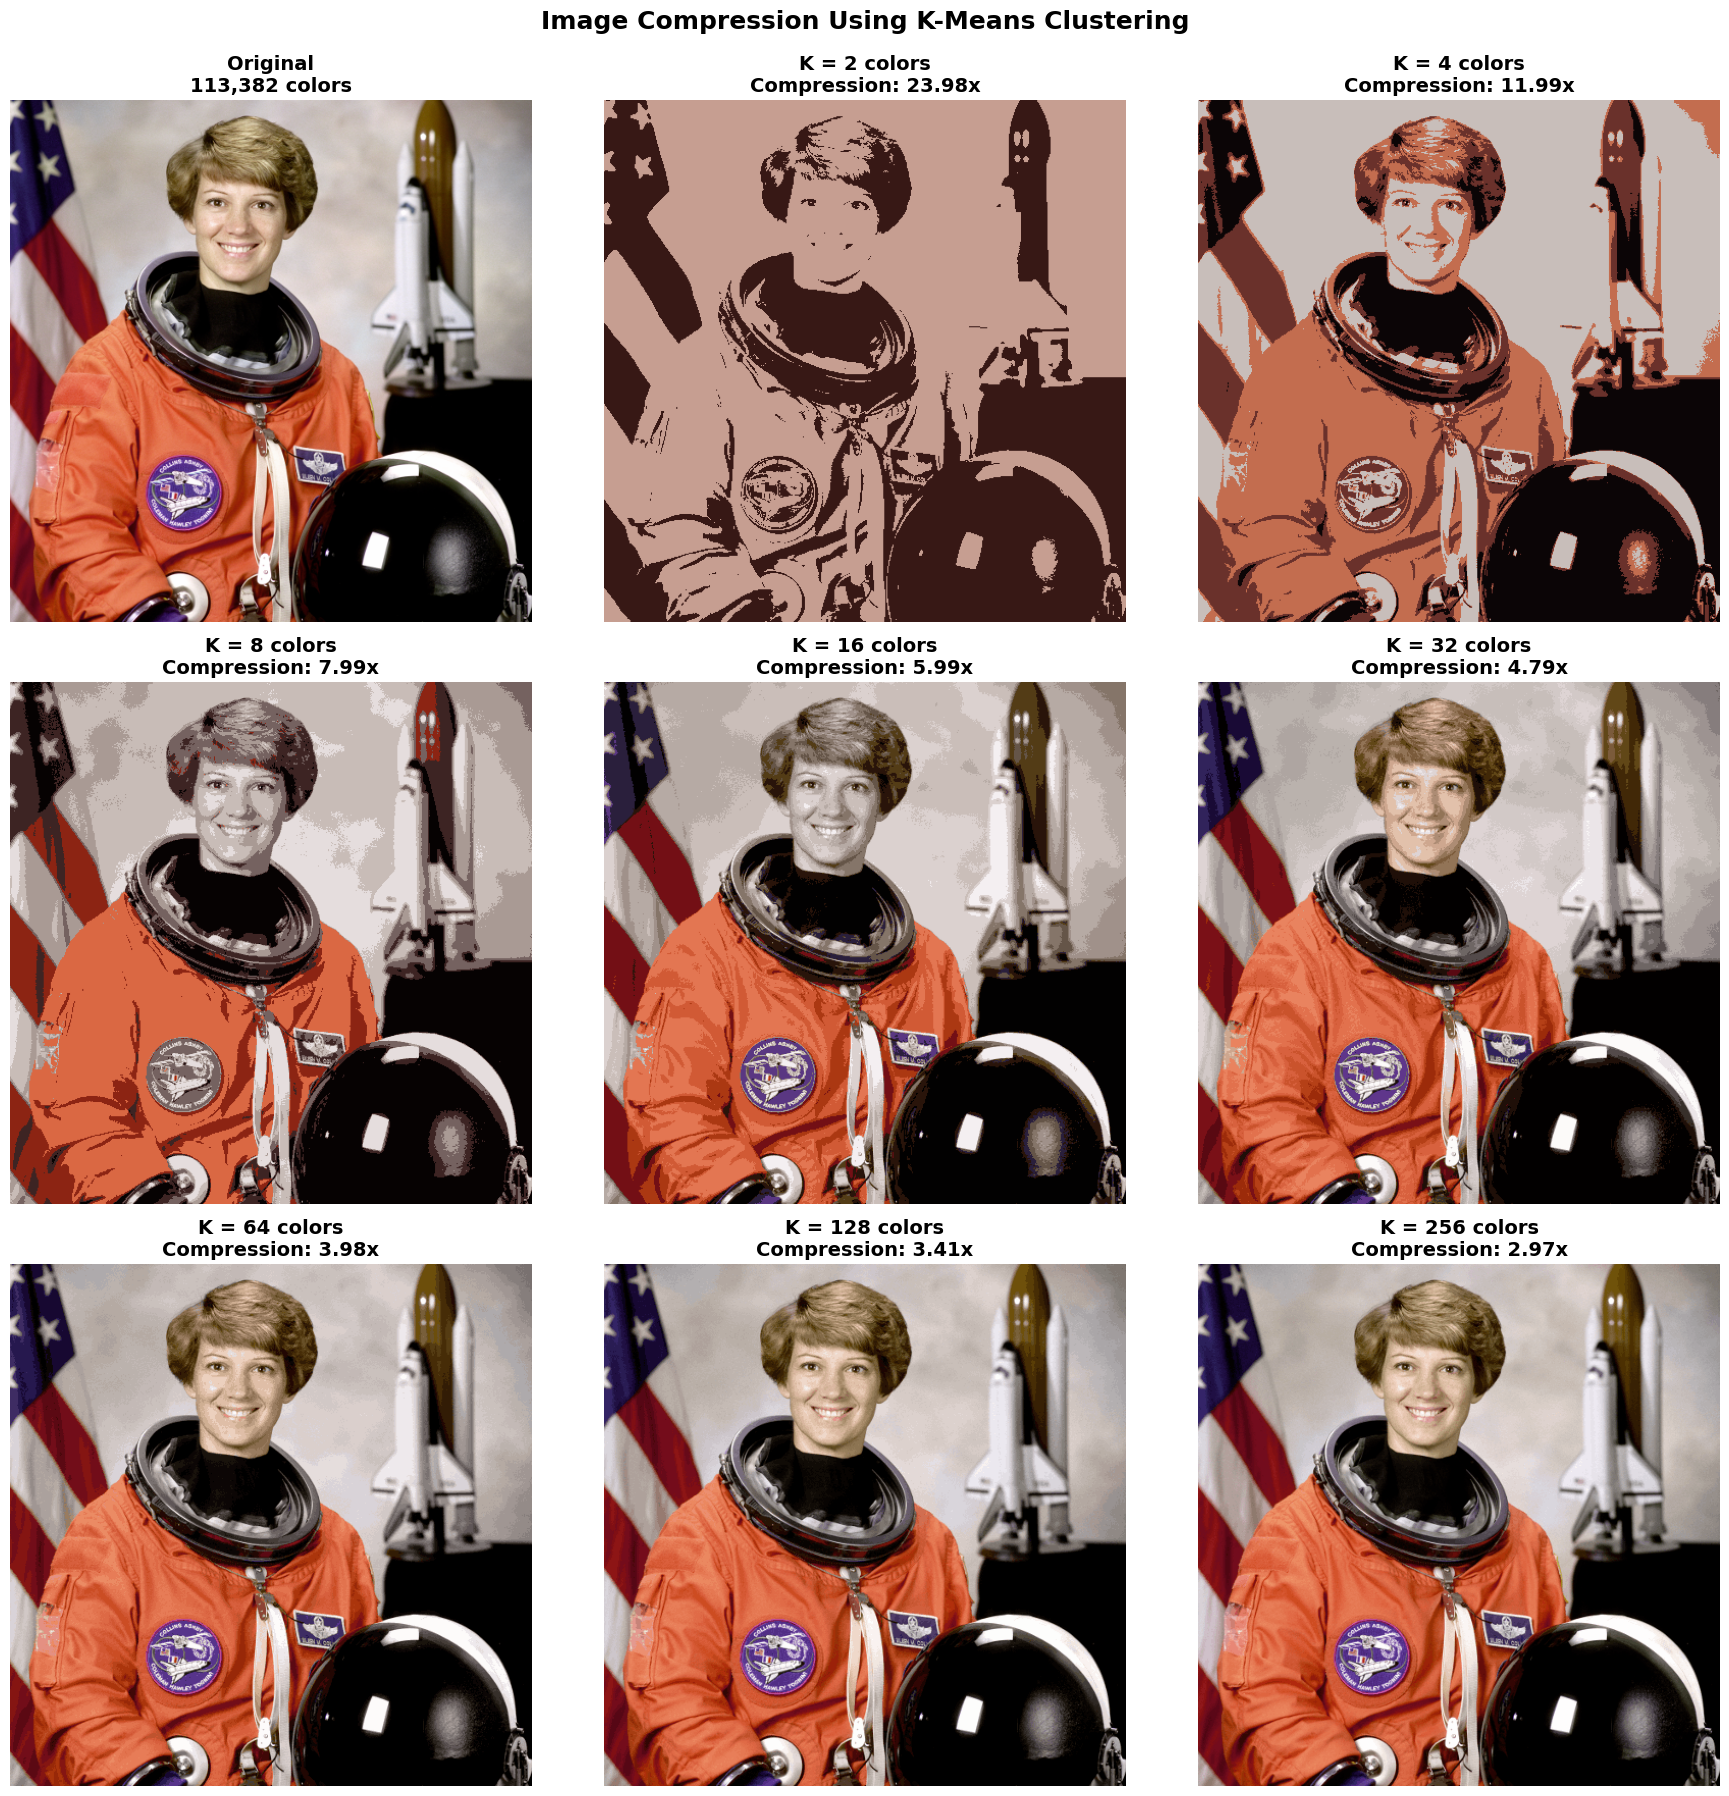

In [6]:
# Create a grid of compressed images
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.ravel()

# Plot original image
axes[0].imshow(image)
axes[0].set_title(f'Original\n{num_unique_colors:,} colors', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Plot compressed images
for idx, k in enumerate(k_values, start=1):
    axes[idx].imshow(compressed_images[k])
    ratio = compression_stats[k]['compression_ratio']
    axes[idx].set_title(f'K = {k} colors\nCompression: {ratio:.2f}x', 
                        fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Image Compression Using K-Means Clustering', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Comparison: Selected Compression Levels

Let's focus on a few key compression levels for detailed comparison.

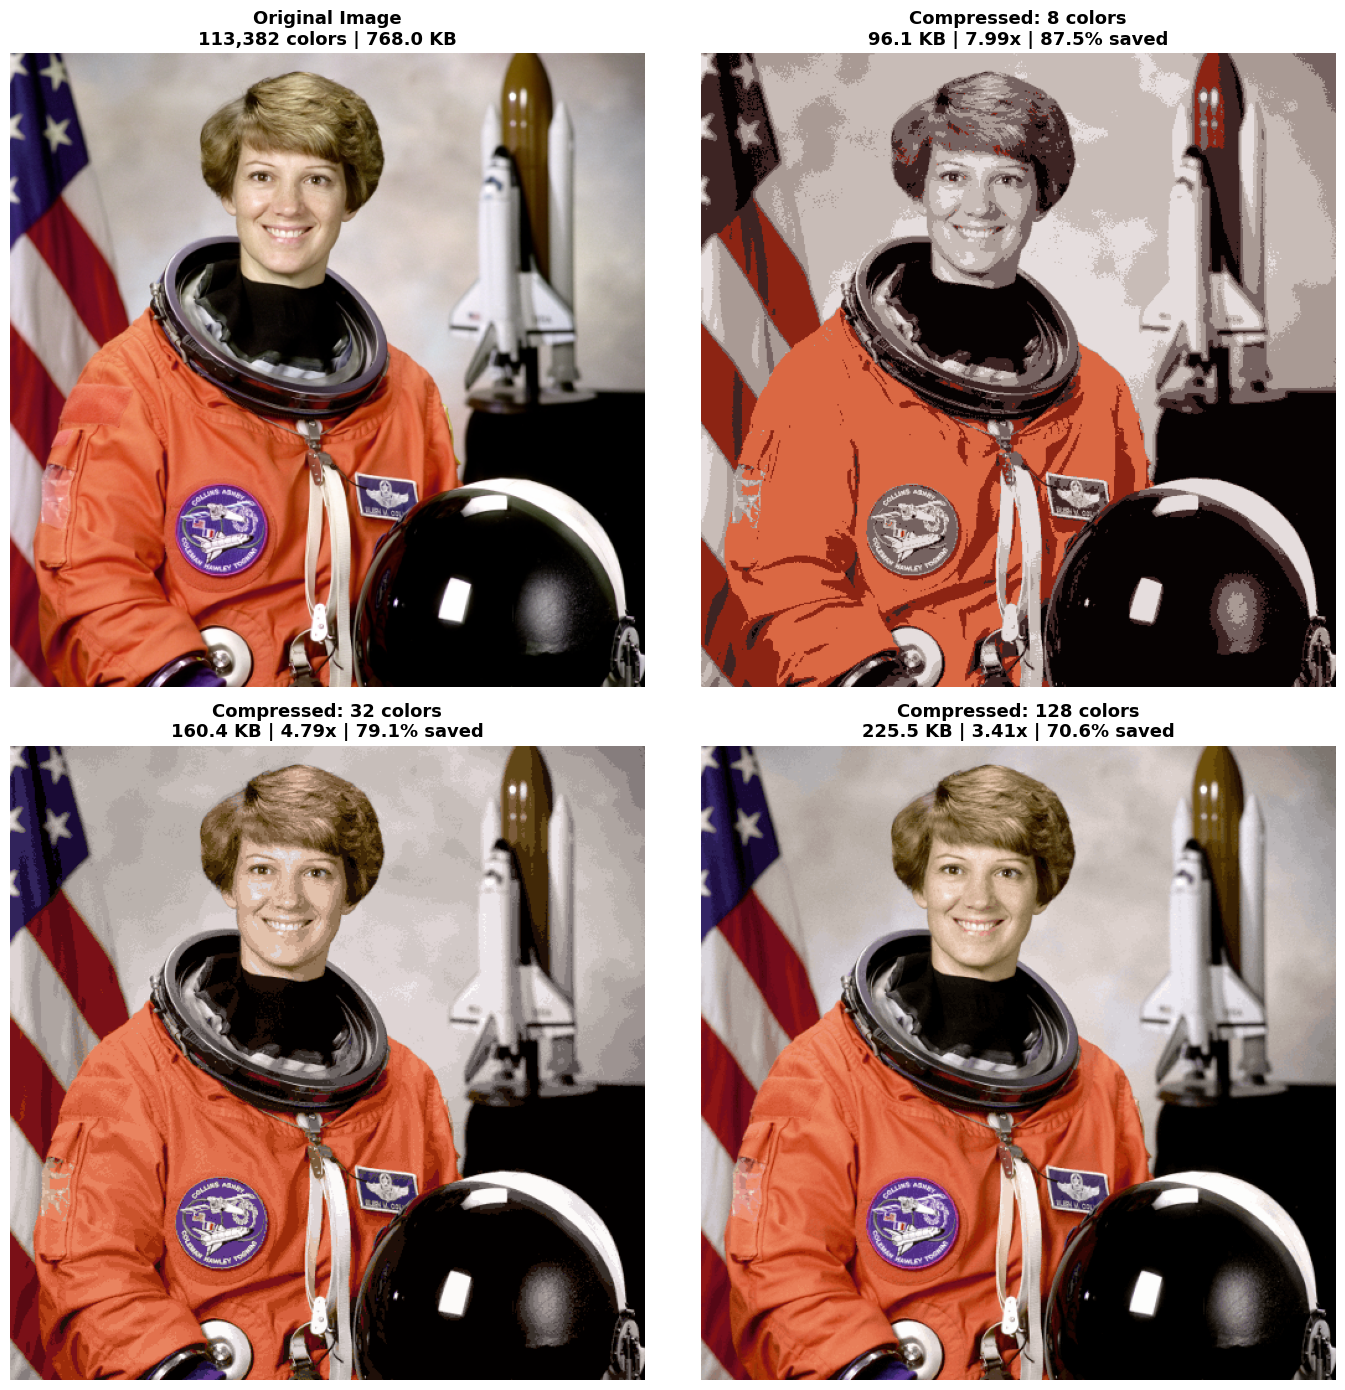

In [7]:
# Select key compression levels for comparison
selected_k = [8, 32, 128]

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.ravel()

# Original
axes[0].imshow(image)
mem_kb = image.nbytes / 1024
axes[0].set_title(f'Original Image\n{num_unique_colors:,} colors | {mem_kb:.1f} KB', 
                  fontsize=13, fontweight='bold')
axes[0].axis('off')

# Compressed versions
for idx, k in enumerate(selected_k, start=1):
    axes[idx].imshow(compressed_images[k])
    stats = compression_stats[k]
    comp_kb = stats['compressed_memory'] / 1024
    title = f'Compressed: {k} colors\n'
    title += f'{comp_kb:.1f} KB | {stats["compression_ratio"]:.2f}x | '
    title += f'{stats["space_saved_percent"]:.1f}% saved'
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 8. Visualize Color Palettes

Show the extracted color palettes for each compression level.

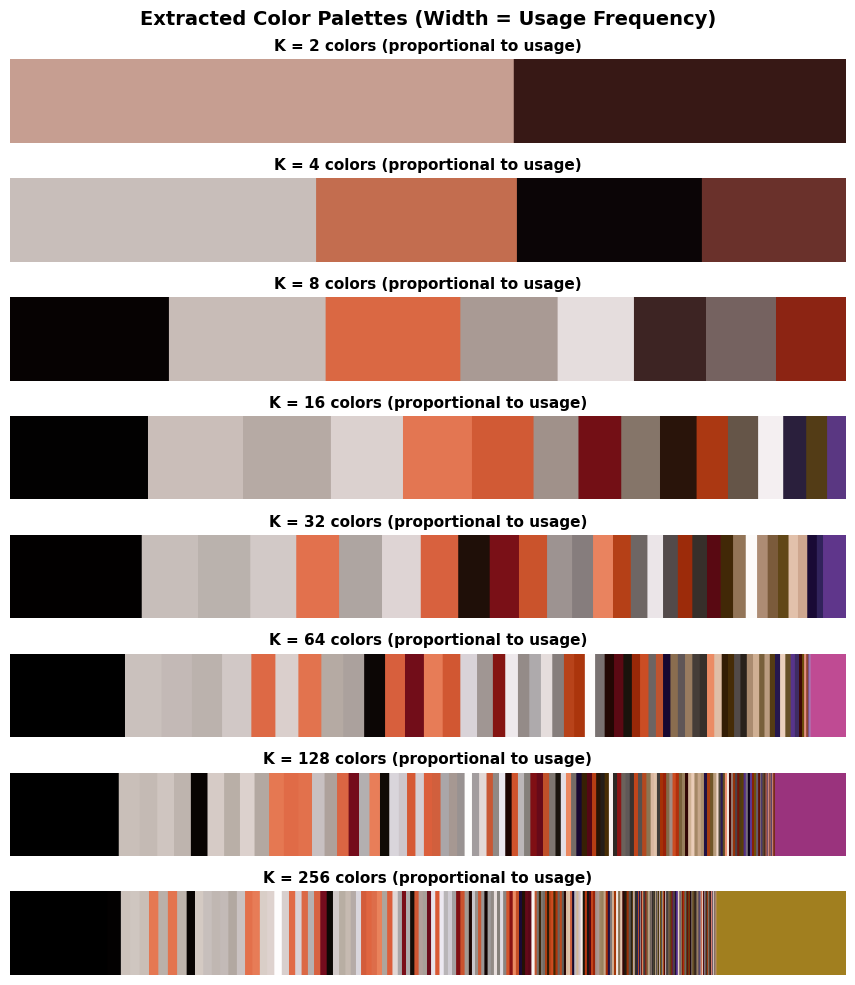

In [8]:
# Create color palette visualization
fig, axes = plt.subplots(len(k_values), 1, figsize=(15, 10))

for idx, k in enumerate(k_values):
    # Get cluster centers (colors)
    centers = kmeans_models[k].cluster_centers_
    palette = np.uint8(centers)
    
    # Get cluster sizes (how many pixels in each cluster)
    labels = kmeans_models[k].labels_
    unique, counts = np.unique(labels, return_counts=True)
    total_pixels = len(labels)
    
    # Sort by cluster size
    sorted_indices = np.argsort(-counts)
    palette = palette[sorted_indices]
    counts = counts[sorted_indices]
    
    # Create color bar proportional to cluster sizes
    color_bar = np.zeros((80, 800, 3), dtype=np.uint8)
    x_pos = 0
    
    for i, (color, count) in enumerate(zip(palette, counts)):
        width = int((count / total_pixels) * 800)
        if i == len(palette) - 1:  # Last color takes remaining space
            width = 800 - x_pos
        color_bar[:, x_pos:x_pos+width] = color
        x_pos += width
    
    axes[idx].imshow(color_bar)
    axes[idx].set_title(f'K = {k} colors (proportional to usage)', 
                        fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Extracted Color Palettes (Width = Usage Frequency)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Compression Performance Analysis

Analyze compression ratio, memory savings, and quality metrics.

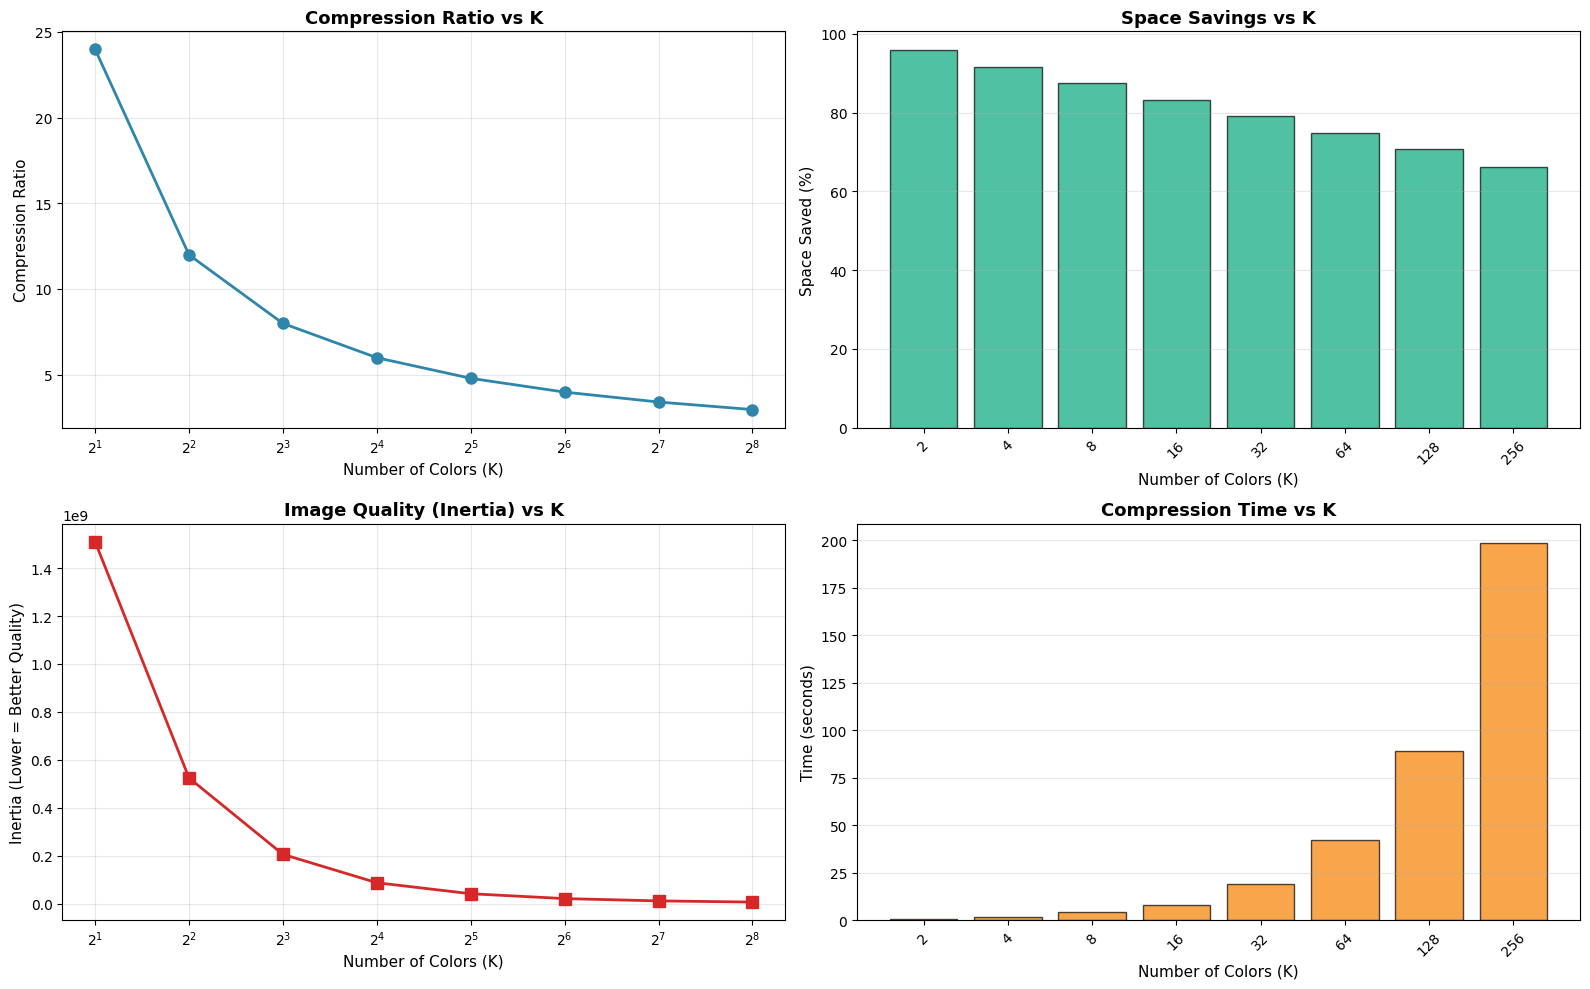

In [9]:
# Extract metrics
compression_ratios = [compression_stats[k]['compression_ratio'] for k in k_values]
space_saved = [compression_stats[k]['space_saved_percent'] for k in k_values]
inertias = [compression_stats[k]['inertia'] for k in k_values]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Compression Ratio
axes[0, 0].plot(k_values, compression_ratios, marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_xlabel('Number of Colors (K)', fontsize=11)
axes[0, 0].set_ylabel('Compression Ratio', fontsize=11)
axes[0, 0].set_title('Compression Ratio vs K', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log', base=2)

# Plot 2: Space Saved
axes[0, 1].bar([f'{k}' for k in k_values], space_saved, color='#06A77D', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Number of Colors (K)', fontsize=11)
axes[0, 1].set_ylabel('Space Saved (%)', fontsize=11)
axes[0, 1].set_title('Space Savings vs K', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Inertia (Quality metric)
axes[1, 0].plot(k_values, inertias, marker='s', linewidth=2, markersize=8, color='#D62828')
axes[1, 0].set_xlabel('Number of Colors (K)', fontsize=11)
axes[1, 0].set_ylabel('Inertia (Lower = Better Quality)', fontsize=11)
axes[1, 0].set_title('Image Quality (Inertia) vs K', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log', base=2)

# Plot 4: Compression Time
times = [compression_times[k] for k in k_values]
axes[1, 1].bar([f'{k}' for k in k_values], times, color='#F77F00', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Number of Colors (K)', fontsize=11)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Compression Time vs K', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Detailed Statistics Table

Print a comprehensive table of compression statistics.

In [10]:
print("\n" + "=" * 100)
print(f"{'COMPRESSION STATISTICS':^100}")
print("=" * 100)
print(f"{'K':<8} {'Original':>12} {'Compressed':>12} {'Ratio':>10} {'Saved':>10} {'Quality':>15} {'Time':>10}")
print(f"{'Colors':<8} {'(KB)':>12} {'(KB)':>12} {'(x)':>10} {'(%)':>10} {'(Inertia)':>15} {'(sec)':>10}")
print("-" * 100)

for k in k_values:
    stats = compression_stats[k]
    orig_kb = stats['original_memory'] / 1024
    comp_kb = stats['compressed_memory'] / 1024
    ratio = stats['compression_ratio']
    saved = stats['space_saved_percent']
    quality = stats['inertia']
    time_sec = compression_times[k]
    
    print(f"{k:<8} {orig_kb:>12.2f} {comp_kb:>12.2f} {ratio:>10.2f} {saved:>10.1f} {quality:>15.0f} {time_sec:>10.3f}")

print("=" * 100)
print("\nNote: Lower inertia indicates better quality (less color distortion)")
print("      Higher compression ratio indicates more space savings")


                                       COMPRESSION STATISTICS                                       
K            Original   Compressed      Ratio      Saved         Quality       Time
Colors           (KB)         (KB)        (x)        (%)       (Inertia)      (sec)
----------------------------------------------------------------------------------------------------
2              768.00        32.02      23.98       95.8      1509238784      0.799
4              768.00        64.05      11.99       91.7       524713248      1.659
8              768.00        96.09       7.99       87.5       206340336      4.236
16             768.00       128.19       5.99       83.3        87969640      7.810
32             768.00       160.38       4.79       79.1        42119548     19.027
64             768.00       192.75       3.98       74.9        21876010     42.321
128            768.00       225.50       3.41       70.6        12274117     89.261
256            768.00       259.00       

## 11. Quality-Size Trade-off Analysis

Visualize the trade-off between compression ratio and image quality.

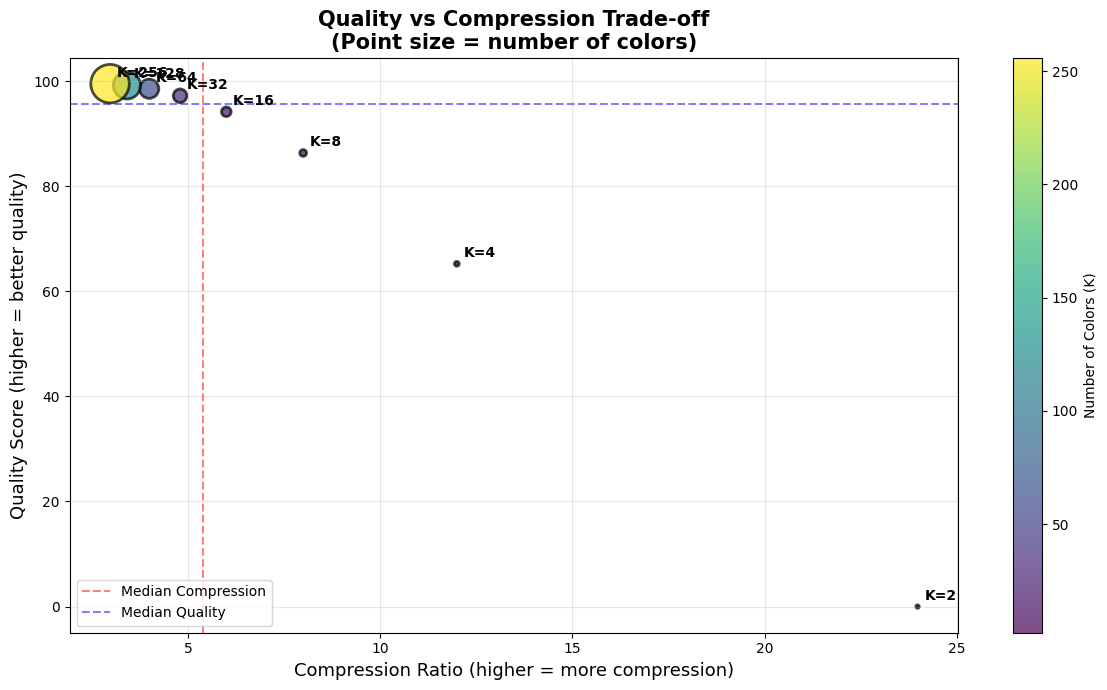


✓ Recommended compression level: K = 8 colors
  Compression ratio: 7.99x
  Quality score: 86.3/100
  Space saved: 87.5%


In [11]:
# Normalize inertia for better visualization (higher = better quality)
max_inertia = max(inertias)
quality_scores = [100 * (1 - inertia/max_inertia) for inertia in inertias]

# Create scatter plot
plt.figure(figsize=(12, 7))
scatter = plt.scatter(compression_ratios, quality_scores, 
                      s=[k*3 for k in k_values], 
                      c=k_values, 
                      cmap='viridis', 
                      alpha=0.7, 
                      edgecolors='black', 
                      linewidth=2)

# Add labels for each point
for k, ratio, quality in zip(k_values, compression_ratios, quality_scores):
    plt.annotate(f'K={k}', 
                xy=(ratio, quality), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10,
                fontweight='bold')

plt.xlabel('Compression Ratio (higher = more compression)', fontsize=13)
plt.ylabel('Quality Score (higher = better quality)', fontsize=13)
plt.title('Quality vs Compression Trade-off\n(Point size = number of colors)', 
          fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Number of Colors (K)')

# Add optimal region annotation
plt.axvline(x=np.median(compression_ratios), color='red', linestyle='--', alpha=0.5, label='Median Compression')
plt.axhline(y=np.median(quality_scores), color='blue', linestyle='--', alpha=0.5, label='Median Quality')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

# Find sweet spot (best balance)
balance_scores = [(r + q) / 2 for r, q in zip(
    [r/max(compression_ratios)*100 for r in compression_ratios], 
    quality_scores
)]
best_idx = np.argmax(balance_scores)
best_k = k_values[best_idx]

print(f"\n✓ Recommended compression level: K = {best_k} colors")
print(f"  Compression ratio: {compression_ratios[best_idx]:.2f}x")
print(f"  Quality score: {quality_scores[best_idx]:.1f}/100")
print(f"  Space saved: {space_saved[best_idx]:.1f}%")

## 12. Optional: Compress Your Own Image

Use the code below to compress your own images.

In [12]:
# Uncomment and modify to use your own image
# custom_image_path = "path/to/your/image.jpg"
# custom_image = io.imread(custom_image_path)

# # Choose compression level
# k_compress = 32

# # Compress
# custom_compressed, _, comp_time, stats = compress_image_kmeans(custom_image, k_compress)

# # Display results
# fig, axes = plt.subplots(1, 2, figsize=(14, 7))
# axes[0].imshow(custom_image)
# axes[0].set_title(f'Original\n{custom_image.nbytes/1024:.1f} KB', fontsize=13)
# axes[0].axis('off')

# axes[1].imshow(custom_compressed)
# axes[1].set_title(f'Compressed ({k_compress} colors)\n{stats["compressed_memory"]/1024:.1f} KB | {stats["compression_ratio"]:.2f}x', fontsize=13)
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

# print(f"Compression ratio: {stats['compression_ratio']:.2f}x")
# print(f"Space saved: {stats['space_saved_percent']:.1f}%")
# print(f"Compression time: {comp_time:.3f} seconds")

print("To compress your own image, uncomment the code above and provide the image path.")

To compress your own image, uncomment the code above and provide the image path.
